## Load Data for Training TimeGAN

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('../data/raw/sp500.csv', index_col='Date', parse_dates=True)

# Convert to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Focus on the 'Close' price
close_prices = data['Close']

# Compute log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Reshape data for TimeGAN (batch, sequence_length, features)
# Since TimeGAN expects a 3D input
log_returns_array = log_returns.values.reshape(-1, 1)

# Normalize data between 0 and 1
scaler = MinMaxScaler()
log_returns_scaled = scaler.fit_transform(log_returns_array)

# Prepare for TimeGAN input (small sequences)
sequence_length = 24  # 24 days (~1 month) for each sequence
sequences = []

for i in range(len(log_returns_scaled) - sequence_length):
    sequences.append(log_returns_scaled[i:i+sequence_length])

sequences = np.array(sequences)

print(f"Shape of prepared data for TimeGAN: {sequences.shape}")


Shape of prepared data for TimeGAN: (6012, 24, 1)


##  Preprocess Data (normalize)

## Build and Train TimeGAN Model

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define TimeGAN model components

# Embedder network
def build_embedder(sequence_length, feature_dim, hidden_dim):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, feature_dim)),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.TimeDistributed(layers.Dense(hidden_dim, activation='sigmoid'))
    ])
    return model

# Recovery network
def build_recovery(sequence_length, hidden_dim, feature_dim):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, hidden_dim)),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.TimeDistributed(layers.Dense(feature_dim, activation='sigmoid'))
    ])
    return model

# Generator network
def build_generator(z_dim, hidden_dim, sequence_length, feature_dim):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, z_dim)),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.TimeDistributed(layers.Dense(feature_dim, activation='sigmoid'))
    ])
    return model

# Discriminator network
def build_discriminator(sequence_length, feature_dim, hidden_dim):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, feature_dim)),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.LSTM(hidden_dim, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
    ])
    return model

print("TimeGAN networks are ready.")

TimeGAN networks are ready.


> ## Assemble and Train the TimeGAN Model

In [4]:
# Define training parameters
hidden_dim = 24
z_dim = 8
sequence_length = 24
feature_dim = 1

batch_size = 128
epochs = 5000

# Build models
embedder = build_embedder(sequence_length, feature_dim, hidden_dim)
recovery = build_recovery(sequence_length, hidden_dim, feature_dim)
generator = build_generator(z_dim, hidden_dim, sequence_length, feature_dim)
discriminator = build_discriminator(sequence_length, feature_dim, hidden_dim)

# Define optimizers
embedder_optimizer = tf.keras.optimizers.Adam()
recovery_optimizer = tf.keras.optimizers.Adam()
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()


# Pre-train Embedder and Recovery (Autoencoder) first
print("Pre-training Embedder and Recovery...")

mse = tf.keras.losses.MeanSquaredError()

for epoch in range(500):
    with tf.GradientTape() as tape:
        # Forward pass
        H = embedder(sequences)
        X_tilde = recovery(H)
        # Reconstruction loss
        loss = mse(sequences, X_tilde)
    gradients = tape.gradient(loss, embedder.trainable_variables + recovery.trainable_variables)
    embedder_optimizer.apply_gradients(zip(gradients, embedder.trainable_variables + recovery.trainable_variables))
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Reconstruction Loss: {loss.numpy():.6f}")

print("Autoencoder pre-training completed!")

Pre-training Embedder and Recovery...
Epoch 0, Reconstruction Loss: 0.003565
Epoch 100, Reconstruction Loss: 0.002746
Epoch 200, Reconstruction Loss: 0.002732
Epoch 300, Reconstruction Loss: 0.002727
Epoch 400, Reconstruction Loss: 0.002725
Autoencoder pre-training completed!


> ## Adversarial Training of Generator and Discriminator

In [5]:
print("Starting Adversarial Training...")

for epoch in range(1000):
    # Random noise for Generator
    Z = np.random.uniform(0, 1, size=(sequences.shape[0], sequence_length, z_dim)).astype(np.float32)
    
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        # Generator forward
        E_hat = generator(Z)
        # Discriminator forward
        Y_fake = discriminator(E_hat)
        Y_real = discriminator(sequences)
        
        # Generator loss: fooling the discriminator
        generator_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(Y_fake), Y_fake)
        
        # Discriminator loss: distinguish real from fake
        discriminator_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(Y_real), Y_real)
        discriminator_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(Y_fake), Y_fake)
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    # Compute gradients
    gradients_gen = tape_gen.gradient(generator_loss, generator.trainable_variables)
    gradients_disc = tape_disc.gradient(discriminator_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Generator Loss: {tf.reduce_mean(generator_loss).numpy():.6f}, Discriminator Loss: {tf.reduce_mean(discriminator_loss).numpy():.6f}")

print("Adversarial training completed!")

Starting Adversarial Training...
Epoch 0, Generator Loss: 0.702135, Discriminator Loss: 1.387408
Epoch 100, Generator Loss: 0.601683, Discriminator Loss: 1.311554
Epoch 200, Generator Loss: 0.697483, Discriminator Loss: 1.414726
Epoch 300, Generator Loss: 0.698280, Discriminator Loss: 1.339873
Epoch 400, Generator Loss: 0.708476, Discriminator Loss: 1.376155
Epoch 500, Generator Loss: 1.580813, Discriminator Loss: 1.899369
Epoch 600, Generator Loss: 0.661717, Discriminator Loss: 1.361795
Epoch 700, Generator Loss: 0.700387, Discriminator Loss: 1.359115
Epoch 800, Generator Loss: 0.682007, Discriminator Loss: 1.388247
Epoch 900, Generator Loss: 0.687230, Discriminator Loss: 1.378401
Adversarial training completed!


## Generate Synthetic Data with TimeGAN

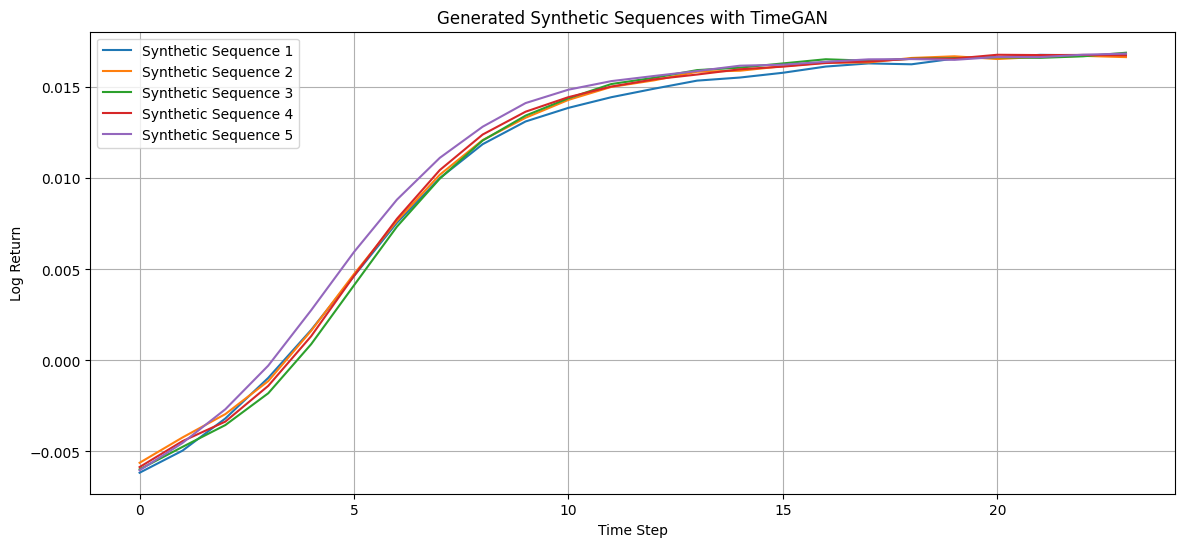

In [6]:
n_samples = 100  # Number of synthetic sequences to generate

# Random noise input for generator
Z_synthetic = np.random.uniform(0, 1, size=(n_samples, sequence_length, z_dim)).astype(np.float32)

# Generate synthetic sequences
synthetic_sequences = generator(Z_synthetic)

# Rescale back to original log-return scale
synthetic_sequences_rescaled = scaler.inverse_transform(synthetic_sequences.numpy().reshape(-1, 1))
synthetic_sequences_rescaled = synthetic_sequences_rescaled.reshape(n_samples, sequence_length)

# Plot a few synthetic sequences
plt.figure(figsize=(14,6))

for i in range(5):
    plt.plot(synthetic_sequences_rescaled[i], label=f'Synthetic Sequence {i+1}')

plt.title('Generated Synthetic Sequences with TimeGAN')
plt.xlabel('Time Step')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

>### Save TimeGAN models

In [8]:
embedder.save('../models/timegan_embedder.h5')
recovery.save('../models/timegan_recovery.h5')
generator.save('../models/timegan_generator.h5')
discriminator.save('../models/timegan_discriminator.h5')

print("TimeGAN models saved.")

TimeGAN models saved.


## Evaluate Synthetic Data with PCA Visualization

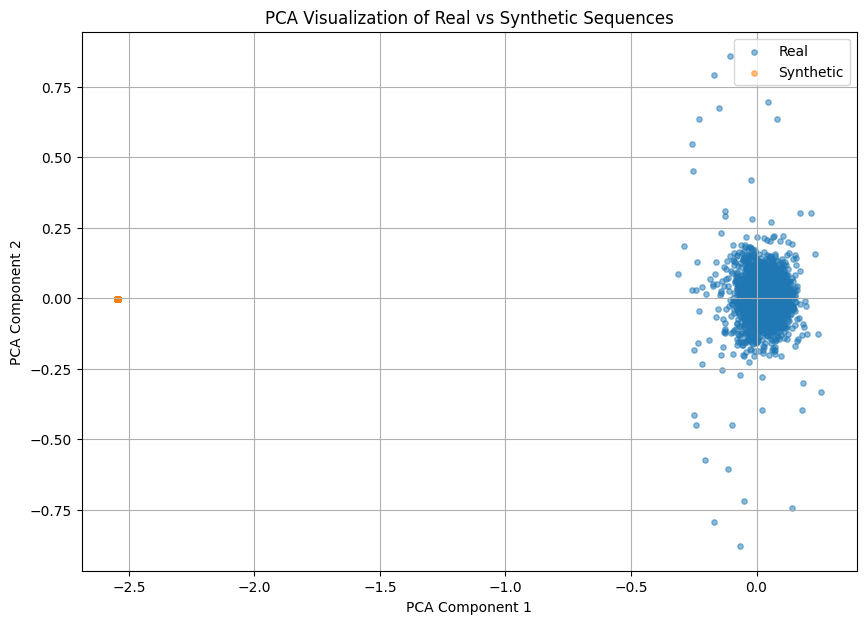

In [9]:
from sklearn.decomposition import PCA

# Prepare real data sequences (for comparison)
real_sequences = sequences.reshape(-1, sequence_length)

# Flatten synthetic sequences (already done in previous step)
synthetic_sequences_flat = synthetic_sequences_rescaled

# Combine real and synthetic
combined_data = np.vstack([real_sequences, synthetic_sequences_flat])
labels = np.array([0]*real_sequences.shape[0] + [1]*synthetic_sequences_flat.shape[0])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)

# Plot PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[labels==0, 0], pca_result[labels==0, 1], alpha=0.5, label='Real', s=15)
plt.scatter(pca_result[labels==1, 0], pca_result[labels==1, 1], alpha=0.5, label='Synthetic', s=15)
plt.title('PCA Visualization of Real vs Synthetic Sequences')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()